<a href="https://colab.research.google.com/github/VangaSravani07/PRODIGY_TrackCode_01/blob/main/Task_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import os

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [3]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
test_ids = test["Id"]  # Save Ids for submission

In [4]:
n_train = train.shape[0]
n_test = test.shape[0]

In [5]:
df = pd.concat([train, test], sort=False).reset_index(drop=True)


In [6]:
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=["object"]).columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])



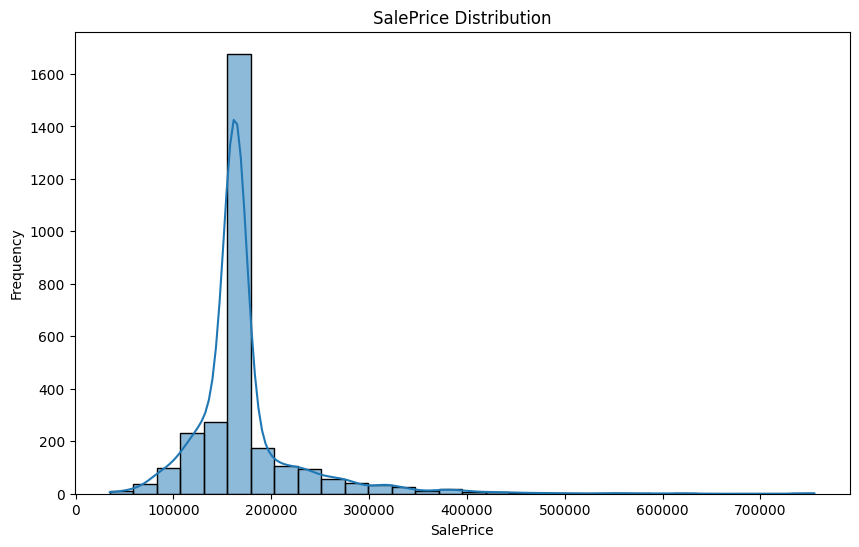

In [7]:
if 'SalePrice' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df['SalePrice'], kde=True, bins=30)
    plt.title("SalePrice Distribution")
    plt.xlabel("SalePrice")
    plt.ylabel("Frequency")
    plt.show()


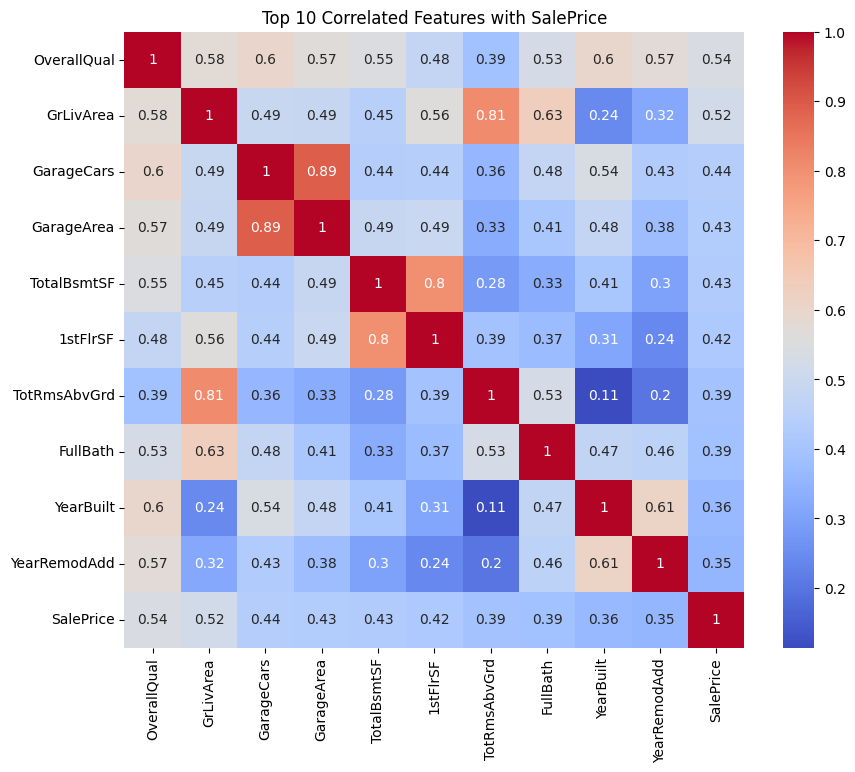

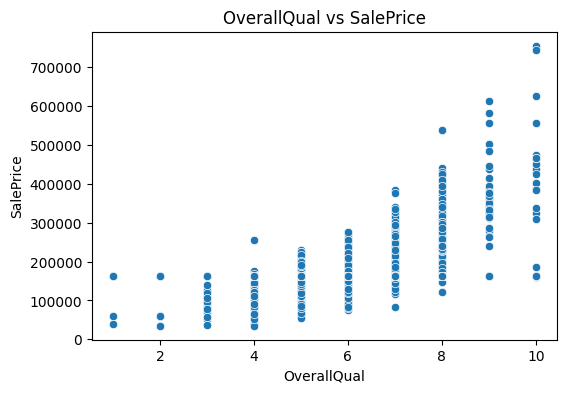

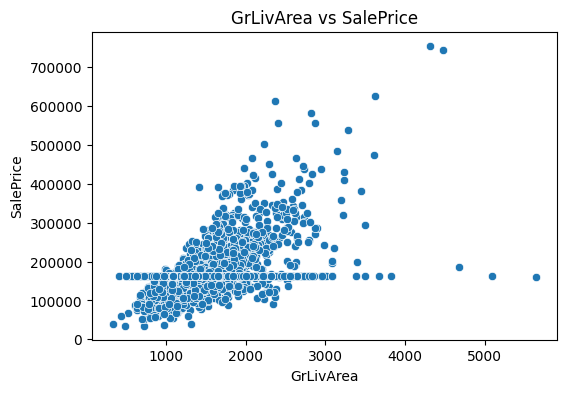

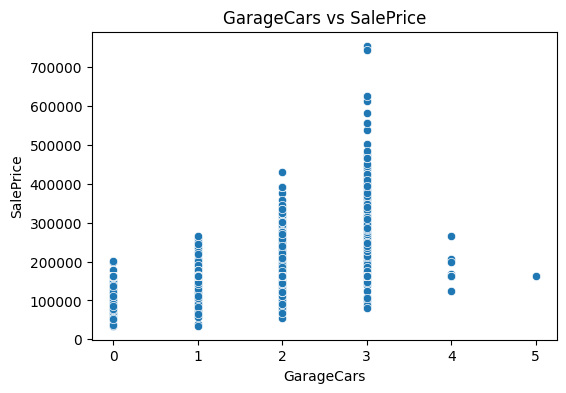

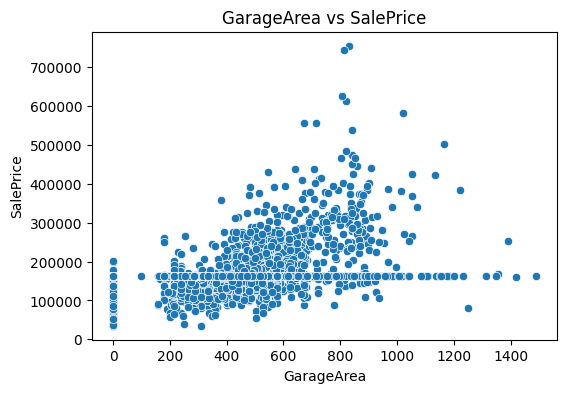

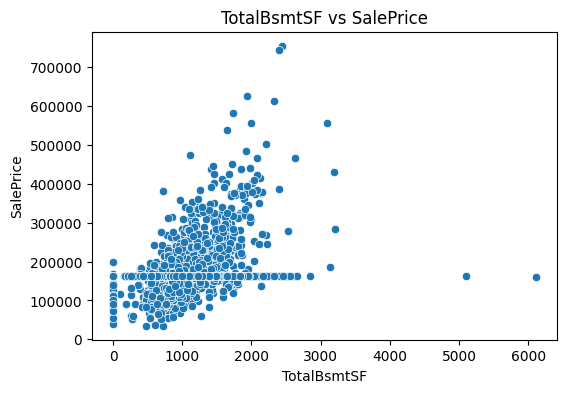

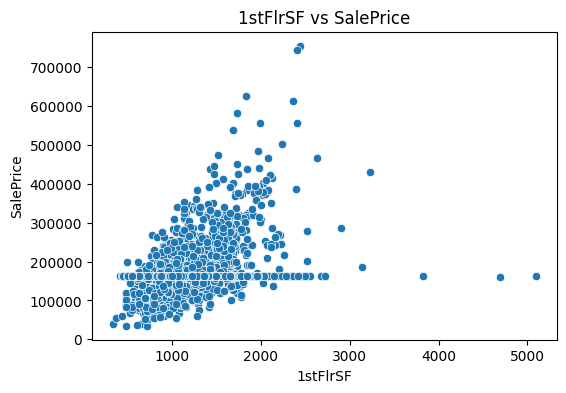

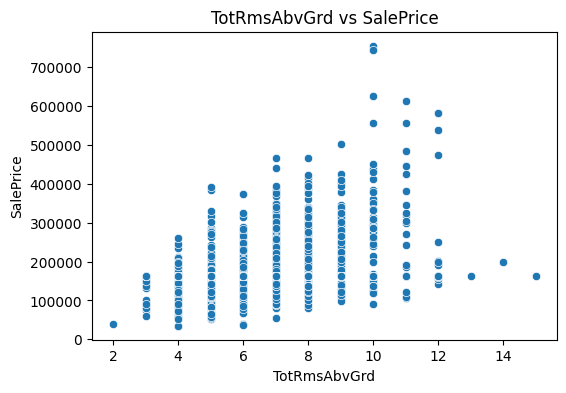

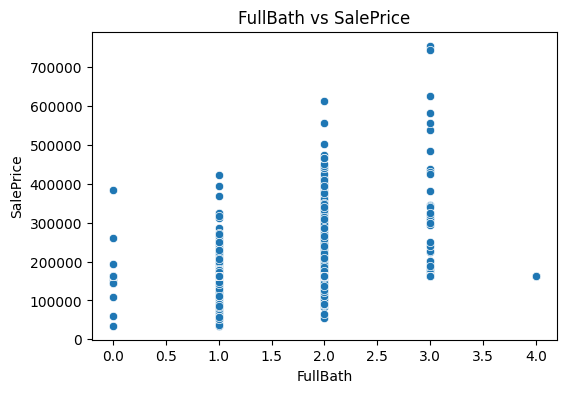

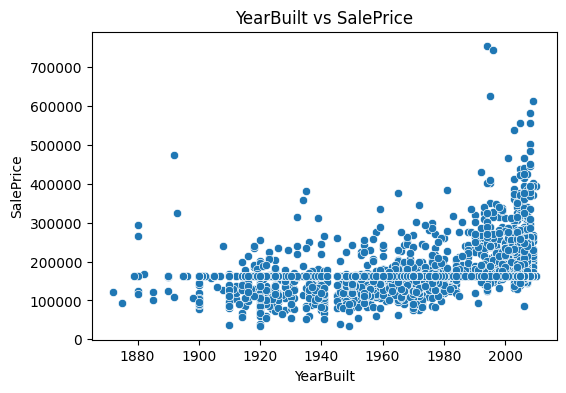

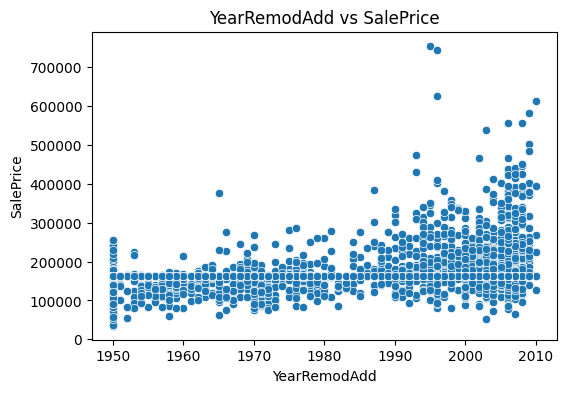

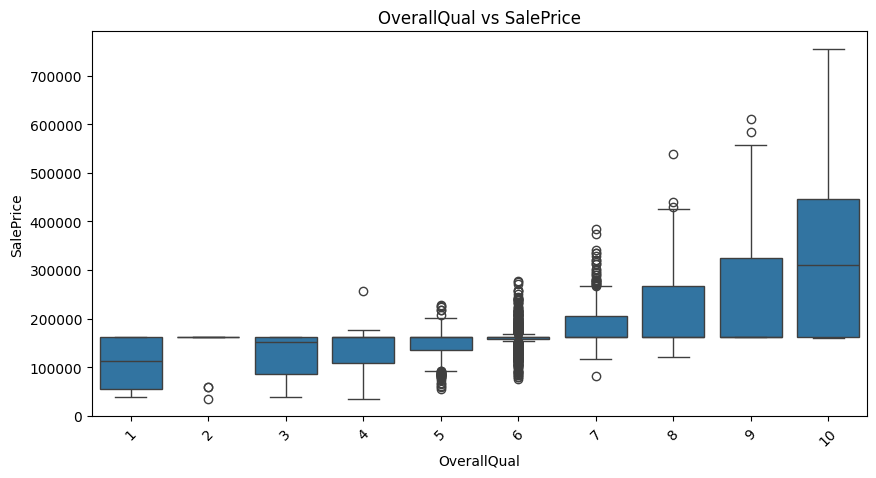

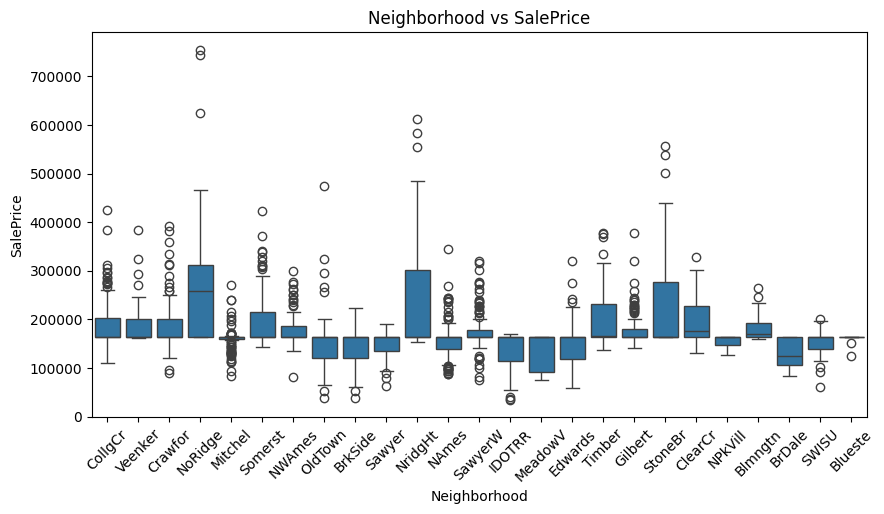

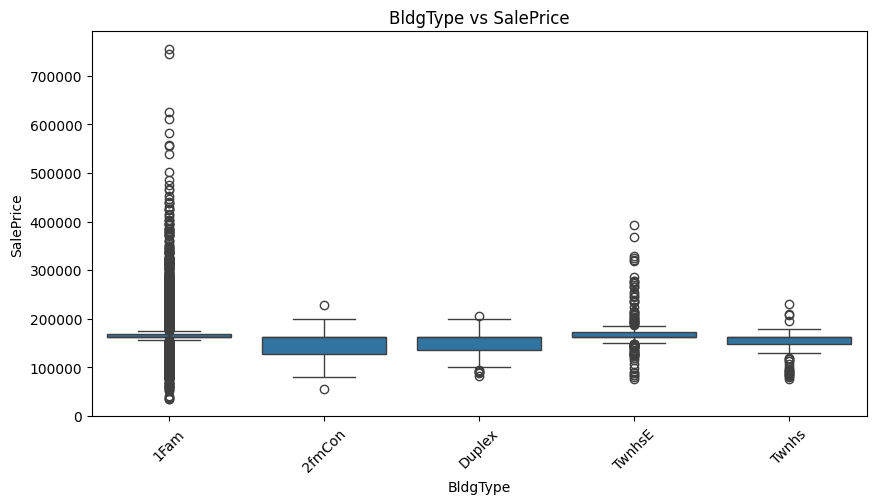

In [8]:
corr_matrix = df[num_cols].corr()
top_corr = corr_matrix['SalePrice'].abs().sort_values(ascending=False)[1:11]
plt.figure(figsize=(10, 8))
sns.heatmap(df[top_corr.index.tolist() + ['SalePrice']].corr(), annot=True, cmap='coolwarm')
plt.title("Top 10 Correlated Features with SalePrice")
plt.show()
for col in top_corr.index.tolist():
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[col], y=df['SalePrice'])
    plt.title(f"{col} vs SalePrice")
    plt.xlabel(col)
    plt.ylabel("SalePrice")
    plt.show()

for col in ['OverallQual', 'Neighborhood', 'BldgType']:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df[col], y=df['SalePrice'])
    plt.xticks(rotation=45)
    plt.title(f"{col} vs SalePrice")
    plt.show()


In [9]:
df_encoded = pd.get_dummies(df)

In [10]:
train_encoded = df_encoded.iloc[:n_train]
test_encoded = df_encoded.iloc[n_train:].drop('SalePrice', axis=1)

X = train_encoded.drop("SalePrice", axis=1)
y = train_encoded["SalePrice"]

In [11]:
test_encoded = test_encoded.reindex(columns=X.columns, fill_value=0)

In [12]:
print("Test shape after encoding and alignment:", test_encoded.shape)
assert test_encoded.shape[0] == n_test, "Mismatch in test prediction rows"

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Test shape after encoding and alignment: (1459, 288)


In [13]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}

In [14]:
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    r2 = r2_score(y_val, preds)
    results.append({"Model": name, "R2 Score": r2, "RMSE": rmse})

results_df = pd.DataFrame(results).sort_values(by="R2 Score", ascending=False)
print("\nModel Comparison:")
print(results_df)


Model Comparison:
              Model  R2 Score          RMSE
4  GradientBoosting  0.906773  26740.984648
5           XGBoost  0.900140  27675.963190
2             Lasso  0.896056  28236.273082
3      RandomForest  0.889229  29148.749028
0  LinearRegression  0.886727  29476.125983
1             Ridge  0.883954  29834.679517


In [15]:
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
best_model.fit(X, y)
test_preds = best_model.predict(test_encoded)

In [16]:
submission = pd.DataFrame({"Id": test_ids.values, "SalePrice": test_preds})
submission.to_csv('/content/sample_submission.csv', index=False)
print(f"\nBest model '{best_model_name}' predictions saved to 'submission.csv'")


Best model 'GradientBoosting' predictions saved to 'submission.csv'
